In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.image as mpimg
import glob
import json
import os
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, sampler
import pandas as pd
import copy


In [2]:
lbls = ["globules", "milia_like_cyst", "negative_network", "pigment_network", "streaks"]


In [3]:
base_root = "/mnt/tank/scratch/nduginets/images/"
masks_path = os.path.join(base_root, "attribute_512p_box/")
segm_path = os.path.join(base_root, "seg_512p_box/")


masks = sorted(glob.glob(masks_path + "ISIC_*"))
segm = sorted(glob.glob(segm_path + "ISIC_*"))

merged_data = []
for idx in range(len(segm)):
    cell = []
    cell.append(segm[idx])
    for jdx in range(0, 5):
        mask_path = masks[idx * 5+ jdx]
        assert lbls[jdx] in mask_path
        cell.append(mask_path)
    merged_data.append(cell)

In [21]:
def draw_items(merged_segm_masks: list, *indexes_to_draw):
    plt.clf()
    if len(indexes_to_draw) == 1:
        fig, plots = plt.subplots(nrows=len(indexes_to_draw) + 1, ncols=6, figsize = (20,20))
    else:
        fig, plots = plt.subplots(nrows=len(indexes_to_draw), ncols=6, figsize = (20,20))
    def draw_row(row_idx, line):
        for idx, i in enumerate(line):
            img = mpimg.imread(i)
            plots[row_idx][idx].imshow(img)
            title = "segmentation"
            if idx > 0:
                title = lbls[idx - 1]
            plots[row_idx][idx].set_title(title)
    for idx, i in enumerate(indexes_to_draw):
        draw_row(idx, merged_segm_masks[i])
    plt.show()


In [22]:

def load_generator(base_path:str):
    model = os.path.join(base_path, "last_model_G.pth")
    return torch.load(model).to("cpu")

def execute_model(model, shape=100, sample_count=10):
    with torch.set_grad_enabled(False):
        z = Variable(torch.tensor(np.random.normal(0, 1, (sample_count, shape)), dtype=torch.float, device="cpu"))
        g_output = model(z)
    return g_output


In [29]:

img_types = ["segm"] + lbls
def build_fill_map(dataset_path):
    frame = pd.read_csv(dataset_path)
    columns = frame.columns[1:]
    def resolve_type(col):
        for t in img_types:
            if t in col:
                return t
        raise Exception("olo lo")
    types_dict = {i: [] for i in img_types}
    column_type = []
    for c in columns:
        t = resolve_type(c)
        types_dict[t].append(c)
        column_type.append(t)

    def group_by_objects(coordinates):
        assert len(coordinates) % 4 == 0
        img_parts = {}
        for i in range(len(coordinates) // 4):
            x = coordinates[i * 4]
            y = coordinates[i * 4 + 1]
            x_sz = coordinates[i * 4 + 2]
            y_sz = coordinates[i * 4 + 3]
            img_parts[i] = [x, y, x_sz, y_sz]
        return img_parts

    max_imgs_on_shape = len(group_by_objects(types_dict["segm"]).keys())
    index_map = {k: group_by_objects(types_dict[k]) for k in types_dict.keys()}
    def resolve_vector(vector: torch.Tensor):
        i_m = copy.deepcopy(index_map)
        for index, value in enumerate(vector):
            t = column_type[index]
            i_m[t][(index // 4) % max_imgs_on_shape][index % 4] = value.item()
        return i_m
    return resolve_vector


def create_img(type_tuples, shifted=False):
    X = 512
    Y = 512
    img = np.zeros((X, Y), dtype=np.int)
    color = 1
    for _, (x, y, x_sz, y_sz) in type_tuples.items():
        if shifted:
            # a = b * 2 - 1
            # b = (a + 1) / 2
            x = (x + 1) / 2
            y = (y + 1) / 2
            x_sz = x_sz / 2
            y_sz = y_sz / 2
            x1 = int(x * X)
            y1 = int(y * Y)
            x2 = x1 + int(x_sz * X)
            y2 = y1 + int(y_sz * Y)
        else:
            x1 = int(x * X)
            y1 = int(y * Y)
            x2 = x1 + int(x_sz * X)
            y2 = y1 + int(y_sz * Y)
        img[x1:x2, y1:y2] = color
        color += 1
    return img




In [30]:

def visualize_generator_output(model, f_m, sample_count = 5):
    assert sample_count > 1
    plt.clf()
    g_outputs = execute_model(model, sample_count=sample_count)
    fig, plots = plt.subplots(nrows=sample_count, ncols=6, figsize = (20,20))

    def draw_row(vector, index):
        resolved = f_m(vector)
        for jdx, title in enumerate(img_types):
            img = create_img(resolved[title])
            plots[index][jdx].imshow(img, interpolation='none')
            plots[index][jdx].set_title(title)
    for idx in range(sample_count):
        v = g_outputs[idx]
        draw_row(v, idx)
    plt.show()

# visualize_generator_output(gen, fill_map, 10)

In [31]:
fill_map = build_fill_map("/mnt/tank/scratch/nduginets/images/isic_2018_boxes.csv")
gen = load_generator("/mnt/tank/scratch/nduginets/GAN_boxed_launches/bs_gan_0")

# GENERATED

/nfs/home/nduginets/miniconda3/envs/with_torch/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<Figure size 432x288 with 0 Axes>

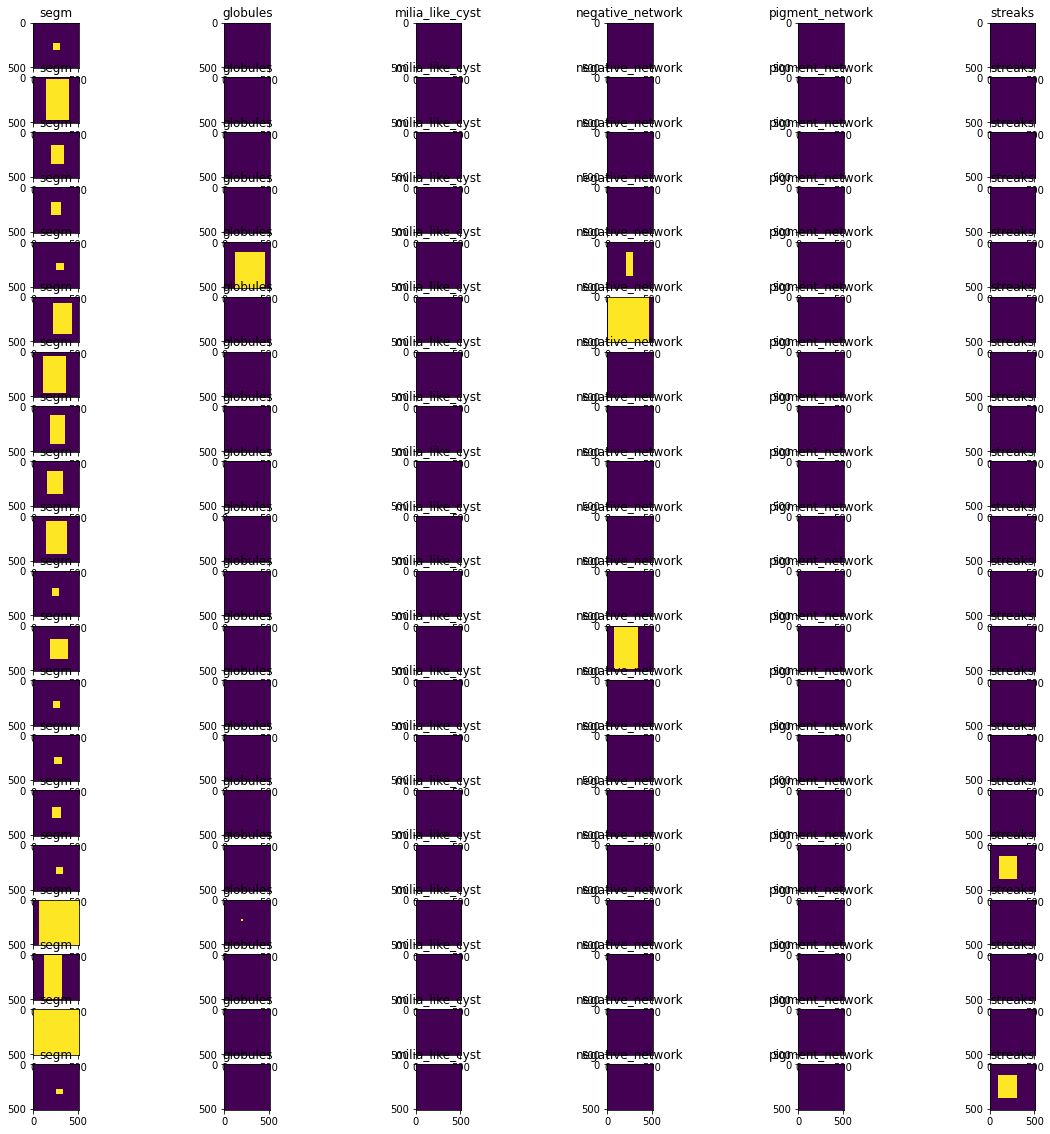

In [32]:
visualize_generator_output(gen, fill_map, 20)

# REAL

<Figure size 432x288 with 0 Axes>

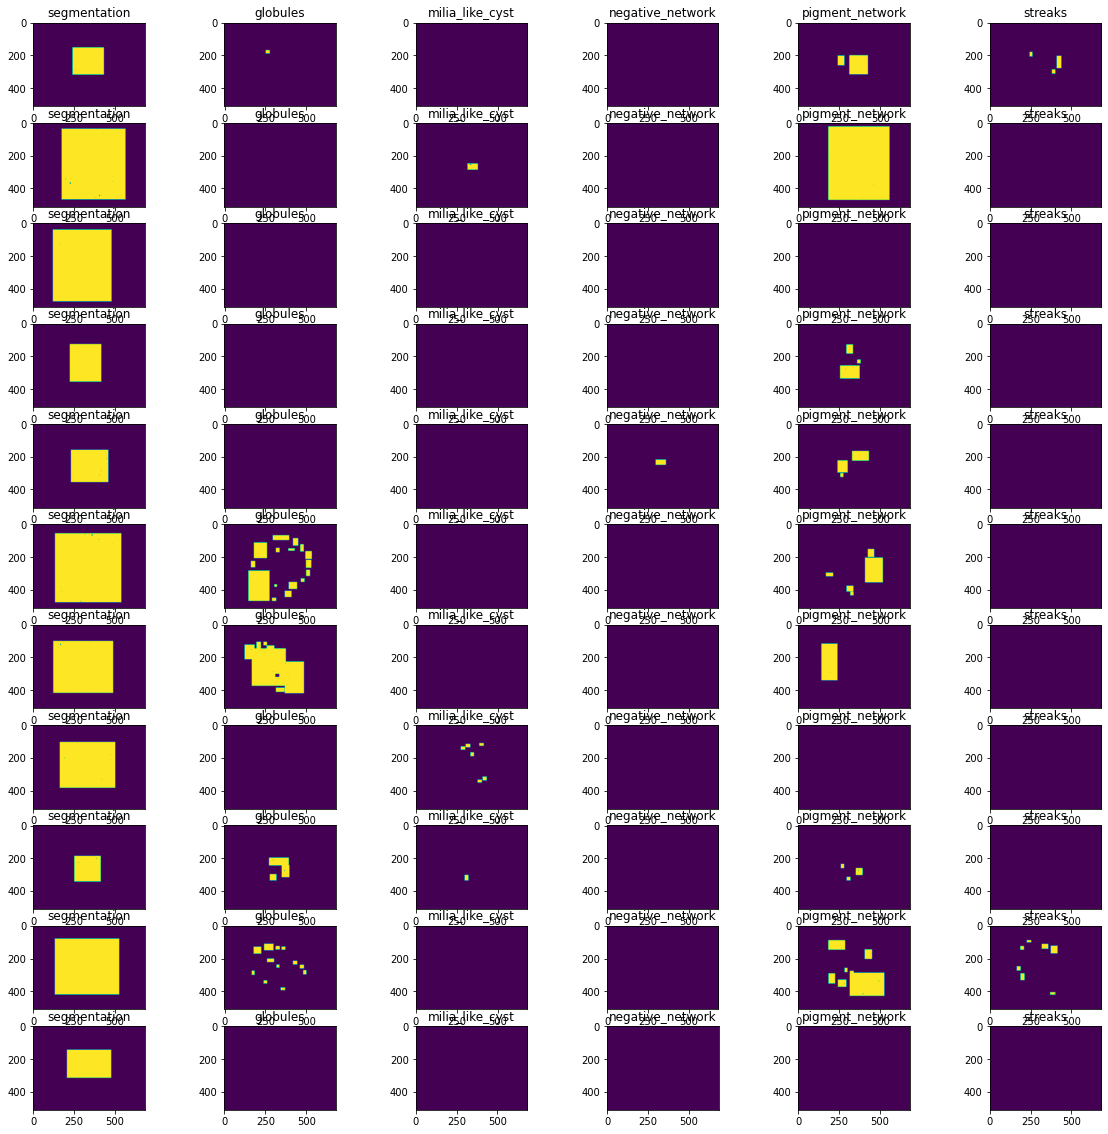

In [20]:
draw_items(merged_data, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100)